In [ ]:
import time
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from types import SimpleNamespace
from qutip import *

from plotstyle import init_style
init_style()

from qspectro2d.config import SCRIPTS_DIR
from qspectro2d.config import create_base_sim_oqs
from qspectro2d.core.bath_system import extract_bath_parameters
from qspectro2d. core import SystemBathCoupling, 
from qspectro2d.core.simulation.redfield_paper import redfield_paper


SyntaxError: trailing comma not allowed without surrounding parentheses (1262870321.py, line 14)

In [7]:
args = SimpleNamespace()
config_path = SCRIPTS_DIR / "config.yaml"


# Build base simulation (applies CLI overrides inside)
sim_oqs, time_cut = create_base_sim_oqs(args, config_path=str(config_path) if config_path else None)

H = sim_oqs.H0_diagonalized
H_int_method = sim_oqs.H_int_sl  # This is a method that takes time as parameter

# Call the method at time=0 to get the actual Hamiltonian
t = sim_oqs.simulation_config.t_coh  # time parameter
H_int = H_int_method(t)  # Now this is a Qobj

# Now you can add them together
total_H = H + H_int
print("Total Hamiltonian at t=t_coh:")
print(total_H)

# For Bloch-Redfield tensor, you typically need the static part
#R_t = bloch_redfield_tensor(total_H, sim_oqs.decay_channels)
#print(R_t[0].tidyup())

🔧 Base simulation created from config (overrides applied early).
🔍 Validating solver...
############################################################
✅ Solver validation worked: Evolution becomes unphysical at (inf × t_max)
Total Hamiltonian at t=t_coh:
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.         0.00963787]
 [0.00963787 0.        ]]


In [8]:
H = sim_oqs.H0_diagonalized
H_int_method = sim_oqs.H_int_sl  # This is a method that takes time as parameter

# Call the method at time=0 to get the actual Hamiltonian
t = 0  # time parameter
H_int = H_int_method(t)  # Now this is a Qobj

# Now you can add them together
total_H = H + H_int
#R_0 = bloch_redfield_tensor(total_H, sim_oqs.decay_channels)
#print(R_0[0])
#print(R_t[0][1])
#print(R_0[0][1])


In [ ]:
print(isinstance(sim_oqs.bath, BosonicEnvironment))
w0 = sim_oqs.system._frequencies_fs[0]
print(extract_bath_parameters(sim_oqs.bath, w0=w0))

True
{'T': 0.0001, 'tag': 'ohmic', 'S(0)': 2.0000000000000002e-11, 'S(w0)': 5.848873038065078e-07, 'alpha': 1.0000000000000001e-07, 'wc': 100.0, 's': 1.0}


/home/leopold/miniconda3/envs/master_env/lib/python3.11/site-packages/qutip/utilities.py:55: RuntimeWarning: overflow encountered in exp
  result[non_zero] = 1 / (np.exp(w[non_zero] / w_th) - 1)


deph_rate_pure: 0.01, down_rate: 292.44365190325385, up_rate: -0.0, coupling: 50.0


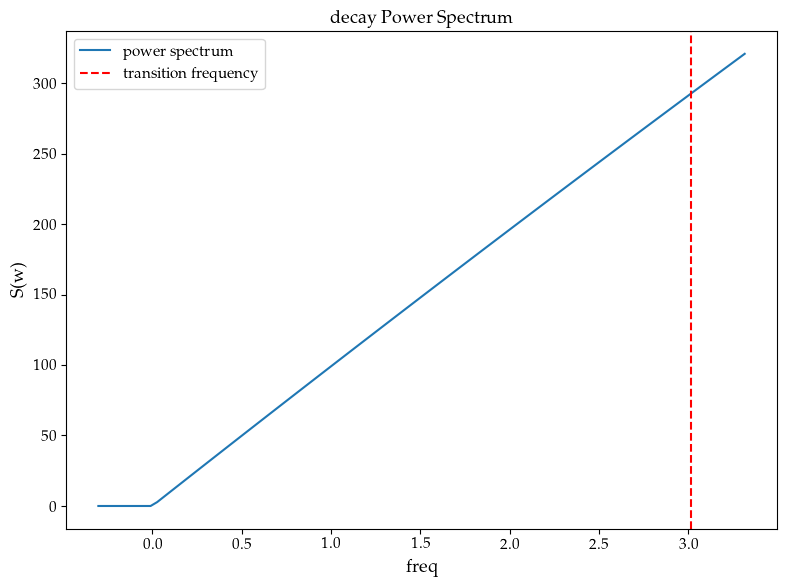

In [10]:
# Rates
gamma_phi = 1 / 100
w0 = sim_oqs.system._frequencies_fs[0]  # transition frequency
from qspectro2d.core.bath_system.bath_fcts import rates_to_alpha, bath_to_rates
alpha = rates_to_alpha(gamma_phi, sim_oqs.bath, w0, mode="deph")
sim_oqs.bath.alpha = alpha  # set the alpha in the bath
deph_rate_pure = bath_to_rates(sim_oqs.bath, mode="deph")  # pure dephasing rate
down_rate, up_rate = bath_to_rates(
    sim_oqs.bath, w0, mode="decay"
)  # emission, absorption
S= sim_oqs.bath.power_spectrum
w_max = sim_oqs.bath.wc  # maximum frequency for the power spectrum
w = np.linspace(-w0/10, 1.1*w0, 100)  # frequency range for the power spectrum

plt.figure()
plt.plot(w, S(w), label='power spectrum')
# plot vertical line at w0
plt.axvline(w0, color='red', linestyle='--', label='transition frequency')
plt.xlabel('freq')
plt.ylabel('S(w)')
plt.title('decay Power Spectrum')
plt.legend()

print(f"deph_rate_pure: {deph_rate_pure}, down_rate: {down_rate}, up_rate: {up_rate}, coupling: {sim_oqs.bath.alpha}")


0.5 0.0025


(<Figure size 800x600 with 2 Axes>, <Axes3D: >)

/home/leopold/miniconda3/envs/master_env/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)


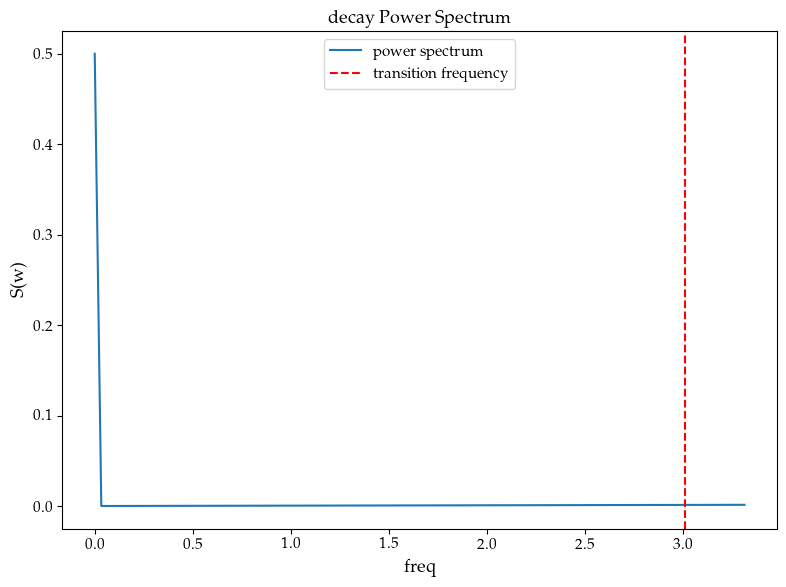

/home/leopold/miniconda3/envs/master_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


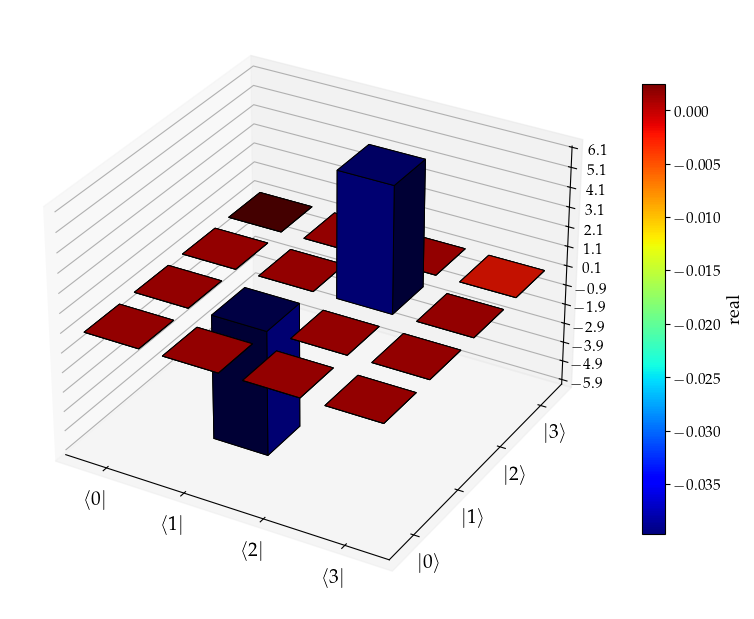

In [ ]:
delta = 0.2 * 2*np.pi
eps0 = 1.0 * 2*np.pi
gamma0 = 0.5
gamma1 = 0.005

H = - delta/2.0 * sigmax() - eps0/2.0 * sigmaz()

def ohmic_spectrum(w):
  if w == 0.0: # dephasing inducing noise
    return gamma0
  else: # relaxation inducing noise
    return gamma1 / 2 * (w / (2 * np.pi)) * (w > 0.0)

g_deph = ohmic_spectrum(0.0)
g_decay = ohmic_spectrum(eps0)
print(g_deph, g_decay)
res = brmesolve(H, basis(2,0), tlist=np.linspace(0, 10, 100), c_ops=[], sec_cutoff=0.1)

w_max = eps0  # maximum frequency for the power spectrum
w = np.linspace(00, 1.1*w0, 100)  # frequency range for the power spectrum
plt.figure()
plt.plot(w, [ohmic_spectrum(x) for x in w], label='power spectrum')
# plot vertical line at w0
plt.axvline(w0, color='red', linestyle='--', label='transition frequency')
plt.xlabel('freq')
plt.ylabel('S(w)')
plt.title('decay Power Spectrum')
plt.legend()


R = bloch_redfield_tensor(H, a_ops=[[sigmax(), ohmic_spectrum],])
matrix_histogram(R[0].tidyup(), bar_style="img")


In [ ]:

# DETAILED BALANCE / KMS CONDITION CHECK
def check_detailed_balance_condition(
    bath: BosonicEnvironment, 
    sb_coupling: SystemBathCoupling, 
    w_range: np.ndarray
) -> None:
    """
    Check if the power spectrum satisfies the detailed balance (KMS) condition.
    
    The KMS condition states: S(-ω) = S(ω) * exp(-ħω/kT)
    For zero temperature: S(-ω) = 0 for ω > 0
    """
    
    ### Bath parameters
    S          = bath.power_spectrum
    kT         = BOLTZMANN * bath.T  # thermal energy
    
    ### Evaluate power spectrum at positive and negative frequencies
    S_positive = np.array([S(w) for w in w_range if w > 0])
    S_negative = np.array([S(-w) for w in w_range if w > 0])
    w_positive = w_range[w_range > 0]
    
    ### Expected ratio from KMS condition
    if bath.T > 1e-10:  # finite temperature
        kms_ratio_expected = np.exp(-HBAR * w_positive / kT)
    else:  # zero temperature limit
        kms_ratio_expected = np.zeros_like(w_positive)
    
    ### Actual ratio from power spectrum
    with np.errstate(divide='ignore', invalid='ignore'):
        kms_ratio_actual = S_negative / S_positive
        kms_ratio_actual = np.where(S_positive == 0, 0, kms_ratio_actual)
    
    ### Plot comparison
    plt.figure(figsize=(12, 8))
    
    ### Power spectrum vs frequency
    plt.subplot(2, 2, 1)
    plt.plot(w_range, [S(w) for w in w_range], 
             label=r'$S(\omega)$', color='C0', linestyle='solid')
    plt.axhline(y=0, color='k', linestyle='dotted', alpha=0.5)
    plt.axvline(x=0, color='k', linestyle='dotted', alpha=0.5)
    plt.xlabel(r'Frequency $\omega$ [fs$^{-1}$]')
    plt.ylabel(r'Power Spectrum $S(\omega)$')
    plt.title(r'Bath Power Spectrum')
    plt.legend()
    
    ### KMS ratio comparison
    plt.subplot(2, 2, 2)
    plt.plot(w_positive, kms_ratio_expected, 
             label=r'Expected: $\exp(-\hbar\omega/k_BT)$', 
             color='C1', linestyle='dashed')
    plt.plot(w_positive, kms_ratio_actual, 
             label=r'Actual: $S(-\omega)/S(\omega)$', 
             color='C0', linestyle='solid')
    plt.xlabel(r'Frequency $\omega$ [fs$^{-1}$]')
    plt.ylabel(r'KMS Ratio')
    plt.title(f'KMS Condition Check ($T = {bath.T:.1e}$ K)')
    plt.legend()
    plt.yscale('log')
    
    ### Relative error
    plt.subplot(2, 2, 3)
    with np.errstate(divide='ignore', invalid='ignore'):
        relative_error = np.abs(kms_ratio_actual - kms_ratio_expected) / np.abs(kms_ratio_expected)
        relative_error = np.where(kms_ratio_expected == 0, 
                                np.abs(kms_ratio_actual), relative_error)
    
    plt.plot(w_positive, relative_error, color='C2', linestyle='solid')
    plt.xlabel(r'Frequency $\omega$ [fs$^{-1}$]')
    plt.ylabel(r'Relative Error')
    plt.title(r'KMS Condition Relative Error')
    plt.yscale('log')
    
    ### Thermal occupation number
    plt.subplot(2, 2, 4)
    if bath.T > 1e-10:
        n_thermal = 1 / (np.exp(HBAR * w_positive / kT) - 1)
        plt.plot(w_positive, n_thermal, color='C3', linestyle='solid')
        plt.xlabel(r'Frequency $\omega$ [fs$^{-1}$]')
        plt.ylabel(r'Thermal Occupation $n(\omega)$')
        plt.title(f'Thermal Occupation Number ($T = {bath.T:.1e}$ K)')
    else:
        plt.text(0.5, 0.5, 'Zero Temperature\n($T \\rightarrow 0$)', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Thermal Occupation Number')
    
    plt.tight_layout()
    plt.show()
    
    ### Print numerical assessment
    print(f"\n{'='*50}")
    print(f"DETAILED BALANCE / KMS CONDITION CHECK")
    print(f"{'='*50}")
    print(f"Bath temperature: {bath.T:.2e} K")
    print(f"Thermal energy kT: {kT:.2e} eV")
    
    if bath.T > 1e-10:
        max_error = np.max(relative_error[np.isfinite(relative_error)])
        mean_error = np.mean(relative_error[np.isfinite(relative_error)])
        print(f"Maximum relative error: {max_error:.2e}")
        print(f"Mean relative error: {mean_error:.2e}")
        
        if max_error < 1e-6:
            print("✅ KMS condition is satisfied (error < 1e-6)")
        elif max_error < 1e-3:
            print("⚠️  KMS condition approximately satisfied (error < 1e-3)")
        else:
            print("❌ KMS condition NOT satisfied (error > 1e-3)")
    else:
        zero_temp_satisfied = np.all(S_negative < 1e-10)
        print(f"Zero temperature condition S(-ω) ≈ 0: {zero_temp_satisfied}")
        if zero_temp_satisfied:
            print("✅ Zero temperature KMS condition satisfied")
        else:
            print("❌ Zero temperature KMS condition NOT satisfied")

check_detailed_balance_condition(bath, sb_coupling, w)